### This is one in a series of scripts that will calculate, for specific centuries, correlations between GHD-Core and the Pauling, Luterbacher, and OWDA reconstructions.

* Spearman's rank correlations.
* This script is specific for years:
#### 1901-1980

In [1]:
%reset -f
#%qtconsole

In [2]:
# Setup the Analysis
import calendar
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm
from IPython.display import display

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# Rectangle Boundaries
lonmin=-2; lonmax=8; latmin=43; latmax=51;

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)

### Load in the GHD data and the individual climate reconstructions.

In [3]:
# Load and properly format wine data
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file

df=pd.read_csv(infile)

# GHD Data to Analyze
ghd_name = 'GHDcore'

# Pull out year and mean as float64
yr       = np.int64(df.Year)
ghd_mean = np.float64(df[ghd_name])

#%%############################################################################
# Load OWDA Data
ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix1_500.nc')

# Load OWDA Variables
lat_pdsi=ncfile_owda.variables['lat'][:];
lon_pdsi=ncfile_owda.variables['lon'][:];
yr_pdsi=ncfile_owda.variables['time'][:];
pdsi=ncfile_owda.variables['pdsi'][:];

# Swap PDSI axes so orientation is correct: time, lat, lon
pdsi=np.swapaxes(pdsi,0,2)

# close file
ncfile_owda.close

#%%############################################################################
# Load Luterbacher Temp Data
ncfile_luter = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/LUTERTEMP/LuterbacherTemp.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_luter = np.arange(1,5); seas_luter_all = np.transpose(np.tile(seas_luter,(1,503)))
yr_luter  = np.arange(1500,2003); 

# Now, pull out each season individually
tmp_locs = np.where(seas_luter_all==1); tmp_locs = tmp_locs[0]; tmp_DJF = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==2); tmp_locs = tmp_locs[0]; tmp_MAM = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==3); tmp_locs = tmp_locs[0]; tmp_JJA = ncfile_luter.variables['temp'][tmp_locs,0,:,:]
tmp_locs = np.where(seas_luter_all==4); tmp_locs = tmp_locs[0]; tmp_SON = ncfile_luter.variables['temp'][tmp_locs,0,:,:]

# close file
ncfile_luter.close

#%%############################################################################
# Load Pauling Precip Data
ncfile_pauling = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/PAULINGPREC/PaulingPrecip.nc')

# Load Variables
lat_prec=ncfile_pauling.variables['lat'][:];
lon_prec=ncfile_pauling.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_paul = np.arange(1,5); seas_paul_all = np.transpose(np.tile(seas_luter,(1,501)))
yr_paul  = np.arange(1500,2001); 

# Now, pull out each season individually
pre_locs = np.where(seas_paul_all==1); pre_locs = pre_locs[0]; pre_DJF = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==2); pre_locs = pre_locs[0]; pre_MAM = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==3); pre_locs = pre_locs[0]; pre_JJA = ncfile_pauling.variables['precip'][pre_locs,0,:,:]
pre_locs = np.where(seas_paul_all==4); pre_locs = pre_locs[0]; pre_SON = ncfile_pauling.variables['precip'][pre_locs,0,:,:]

# close file
ncfile_pauling.close

<function Dataset.close>

### Now, for each century, pull out all the GHD and climate data and conduct point by point correlations. In this way, we can see if the relationships are stationary. This may be especially important for pre- and post- 1900, when there are significant root stock changes in the wineries.
* Setup up base period and pool out the relevant data.

In [4]:
# Base period to conduct correlations over. Remember, last year you want, add one.
base_period = np.arange(1901,1981)   

# Now, find these year locations in each dataset
i_yr_ghd  = np.where( (yr>=np.min(base_period))       & (yr<=np.max(base_period)))[0]
i_yr_temp = np.where( (yr_luter>=np.min(base_period)) & (yr_luter<=np.max(base_period)))[0]
i_yr_prec = np.where( (yr_paul>=np.min(base_period))  & (yr_paul<=np.max(base_period)))[0]
i_yr_pdsi = np.where( (yr_pdsi>=np.min(base_period))  & (yr_pdsi<=np.max(base_period)))[0]

# Now, subset the data
sub_ghd  = ghd_mean[i_yr_ghd]
sub_temp = tmp_JJA[i_yr_temp,:,:]
sub_prec = pre_JJA[i_yr_prec,:,:]
sub_pdsi = pdsi[i_yr_pdsi,:,:]

# Arrays to store regional average PDSI/Temp/Precip for each site
pdsi_coswtmean = np.zeros((np.size(base_period)))
tmp_coswtmean  = np.zeros((np.size(base_period)))
pre_coswtmean  = np.zeros((np.size(base_period)))

# Latitude/Longitude range for averaging
print("lat range = ("+np.str(latmin)+" to "+np.str(latmax)+")")
print("lon range = ("+np.str(lonmin)+" to "+np.str(lonmax)+")")


lat range = (43 to 51)
lon range = (-2 to 8)


### Create regional average series of Temp, Prec, and PDSI over the core region.

In [5]:
# TEMPERATURE----------------------------------------------------------------------------------------------------------
i_lat_reg = np.where((lat_temp>=latmin) & (lat_temp<=latmax))[0]; lat_reg = lat_temp[i_lat_reg]
i_lon_reg = np.where((lon_temp>=lonmin) & (lon_temp<=lonmax))[0]; lon_reg = lon_temp[i_lon_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)
        
# Load Each Year and Spatially Average
for i_yr in enumerate(base_period):
    #print(i_yr)
    # Pull out Current Month Temp/Precip
    temp_curr = sub_temp[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        
    # Cosine Weighted Average
    tmp_coswtmean[i_yr[0]]  = np.ma.average(np.ma.masked_invalid(temp_curr),weights=lat_wts_grid)

# PRECIPITATION--------------------------------------------------------------------------------------------------------
i_lat_reg = np.where((lat_prec>=latmin) & (lat_prec<=latmax))[0]; lat_reg = lat_prec[i_lat_reg]
i_lon_reg = np.where((lon_prec>=lonmin) & (lon_prec<=lonmax))[0]; lon_reg = lon_prec[i_lon_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)
        
# Load Each Year and Spatially Average
for i_yr in enumerate(base_period):
    #print(i_yr)
    # Pull out Current Month Temp/Precip
    prec_curr = sub_prec[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        
    # Cosine Weighted Average
    pre_coswtmean[i_yr[0]]  = np.ma.average(np.ma.masked_invalid(prec_curr),weights=lat_wts_grid)
    
# PDSI--------------------------------------------------------------------------------------------------------
i_lat_reg = np.where((lat_pdsi>=latmin) & (lat_pdsi<=latmax))[0]; lat_reg = lat_pdsi[i_lat_reg]
i_lon_reg = np.where((lon_pdsi>=lonmin) & (lon_pdsi<=lonmax))[0]; lon_reg = lon_pdsi[i_lon_reg]

# Create Latitude Weights
lat_wts               = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid          = np.swapaxes(lat_wts_grid,1,0)
        
# Load Each Year and Spatially Average
for i_yr in enumerate(base_period):
    #print(i_yr)
    # Pull out Current Month Temp/Precip
    pdsi_curr = sub_pdsi[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        
    # Cosine Weighted Average
    pdsi_coswtmean[i_yr[0]]  = np.ma.average(np.ma.masked_invalid(pdsi_curr),weights=lat_wts_grid)
     

### Create Regression Plots

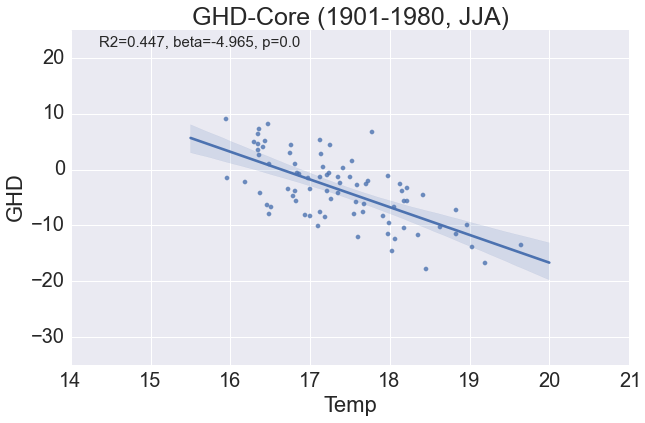

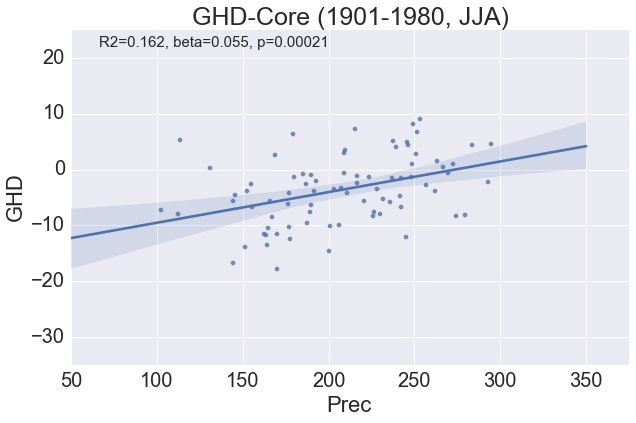

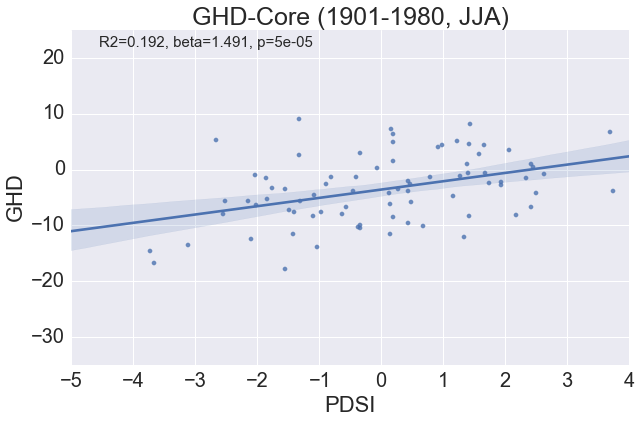

In [6]:
# Create Data Frame first to store the data
df_siteclim = pd.DataFrame(index=base_period, columns=['GHD','Temp','Prec','PDSI'])
    
# Populate Dataframe for regression plots
df_siteclim.GHD  = np.float64(sub_ghd)
df_siteclim.Temp = np.float64(tmp_coswtmean)
df_siteclim.Prec = np.float64(pre_coswtmean)
df_siteclim.PDSI = np.float64(pdsi_coswtmean)  

# Axis Limits
limit_ghd=np.float64([-35,25]); 
limit_temp=np.float64([14,21]); 
limit_prec=np.float64([50,375]); 
limit_pdsi=np.float64([-5,4]);
    
# TEMPERATURE FIGURE-------------------------------------------------------------------------------------------------
# Setup Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.0)
sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
sns.plt.figure(figsize=[10,6])
sns.plt.title('GHD-Core ('+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+', JJA)',fontsize=25)
sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
sns.plt.ylim(limit_ghd)
sns.plt.xlim(limit_temp)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
sns.plt.tight_layout
sns.plt.savefig('../figures/step03/ghdcore.regress.temp.century.'+np.str(np.min(base_period))+ \
                    '-'+np.str(np.max(base_period))+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   

# PRECIPITATION FIGURE-------------------------------------------------------------------------------------------------
# Setup Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.0)
sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
sns.plt.figure(figsize=[10,6])
sns.plt.title('GHD-Core ('+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+', JJA)',fontsize=25)
sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
sns.plt.ylim(limit_ghd)
sns.plt.xlim(limit_prec)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
sns.plt.tight_layout
sns.plt.savefig('../figures/step03/ghdcore.regress.prec.century.'+np.str(np.min(base_period))+ \
                    '-'+np.str(np.max(base_period))+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   

# PDSI FIGURE----------------------------------------------------------------------------------------------------------
# Setup Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.0)
sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
sns.plt.figure(figsize=[10,6])
sns.plt.title('GHD-Core ('+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+', JJA)',fontsize=25)
sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
sns.plt.ylim(limit_ghd)
sns.plt.xlim(limit_pdsi)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
sns.plt.tight_layout
sns.plt.savefig('../figures/step03/ghdcore.regress.pdsi.century.'+np.str(np.min(base_period))+ \
                    '-'+np.str(np.max(base_period))+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   

       
    

### Conduct and plot the temperature correlations.

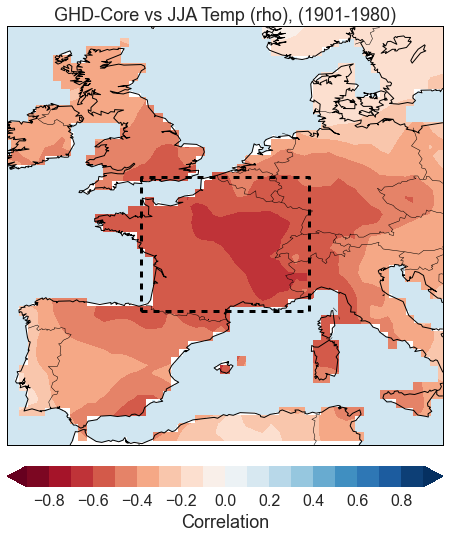

In [7]:
# CORRELATIONS: POINT BY POINT WITH TEMPERATURE----------------------------------------------------------
rho_ghd_vs_temp = np.zeros((np.size(lat_temp),np.size(lon_temp)))*np.nan; 

for n_lat in enumerate(lat_temp):
    for n_lon in enumerate(lon_temp):
    
        # Pull out Individual gridcell pdsi/temp/prec
        temp_seas_cell = sub_temp[:,n_lat[0],n_lon[0]]

        # Put in NaN if ocean areas (missing values)
        if temp_seas_cell[0]>900:

            rho_ghd_vs_temp[n_lat[0],n_lon[0]]  = np.nan
        
        # Calculate the correlation if a legitimate observation
        else:   
                             
            # Spearman rank correlations: Temp
            rho,pval = stats.spearmanr(temp_seas_cell,sub_ghd)    
            rho_ghd_vs_temp[n_lat[0],n_lon[0]]  = rho
            
# Mapping Parameters------------------------------------------------------------------------------
# Set Map Limits and coordinates for mapping
lon_map = lon_temp; lat_map = lat_temp;

lonlim=np.array([-10,16]);
latlim=np.array([35,60]);
#lonlim=np.array([np.min(lon_temp),np.max(lon_temp)]);
#latlim=np.array([np.min(lat_temp),np.max(lat_temp)]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
lon_map, lat_map = np.meshgrid(lon_map, lat_map)

site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

# Map of Temperature Correlations
title_txt = 'GHD-Core vs JJA Temp (rho), ('+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+')'
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# (2) SETUP PROJECTION
m = Basemap(projection=proj_txt,resolution='l',\
        llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
        urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
# (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
# draw meridians
meridians = np.arange(180.,360.,10.)
# (4) COMPUTE MAP PROJECTION COORDINATES
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
cs = m.contourf(x,y,rho_ghd_vs_temp,clevs,cmap=plt.cm.RdBu,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
#    # (7) DRAW SITE LOCATION
#    x_loc, y_loc = m(lon_site,lat_site)
#    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
# (8) ADD COLORBAR AND TITLE
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Correlation',fontsize=18)
plt.title(title_txt,fontdict)
cbar.ax.tick_params(labelsize=16)
# (9) SAVE TO OUTPUT
plt.show()
out_txt = '../figures/step03/corrmap.ghdcore.vs.tmpJJA.'+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+'.eps'
fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator           
            

### Conduct and plot the precipitation correlations.

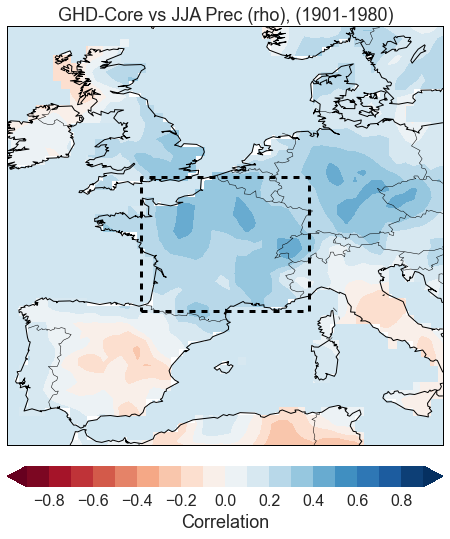

In [8]:
# CORRELATIONS: POINT BY POINT WITH PRECIPITATION----------------------------------------------------------
rho_ghd_vs_prec = np.zeros((np.size(lat_prec),np.size(lon_prec)))*np.nan; 

for n_lat in enumerate(lat_prec):
    for n_lon in enumerate(lon_prec):
    
        # Pull out Individual gridcell pdsi/temp/prec
        prec_seas_cell = sub_prec[:,n_lat[0],n_lon[0]]

        # Put in NaN if ocean areas (missing values)
        if prec_seas_cell[0]>900:

            rho_ghd_vs_prec[n_lat[0],n_lon[0]]  = np.nan
        
        # Calculate the correlation if a legitimate observation
        else:   
                             
            # Spearman rank correlations: Temp
            rho,pval = stats.spearmanr(prec_seas_cell,sub_ghd)    
            rho_ghd_vs_prec[n_lat[0],n_lon[0]]  = rho
            
# Mapping Parameters------------------------------------------------------------------------------
# Set Map Limits and coordinates for mapping
lon_map = lon_prec; lat_map = lat_prec;

lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
lon_map, lat_map = np.meshgrid(lon_map, lat_map)

site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

# Map of Temperature Correlations
title_txt = 'GHD-Core vs JJA Prec (rho), ('+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+')'
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# (2) SETUP PROJECTION
m = Basemap(projection=proj_txt,resolution='l',\
        llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
        urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
# (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
# draw meridians
meridians = np.arange(180.,360.,10.)
# (4) COMPUTE MAP PROJECTION COORDINATES
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
cs = m.contourf(x,y,rho_ghd_vs_prec,clevs,cmap=plt.cm.RdBu,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
#    # (7) DRAW SITE LOCATION
#    x_loc, y_loc = m(lon_site,lat_site)
#    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
# (8) ADD COLORBAR AND TITLE
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Correlation',fontsize=18)
plt.title(title_txt,fontdict)
cbar.ax.tick_params(labelsize=16)
# (9) SAVE TO OUTPUT
plt.show()
out_txt = '../figures/step03/corrmap.ghdcore.vs.preJJA.'+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+'.eps'
fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator           
            

### Conduct and plot the PDSI correlations.

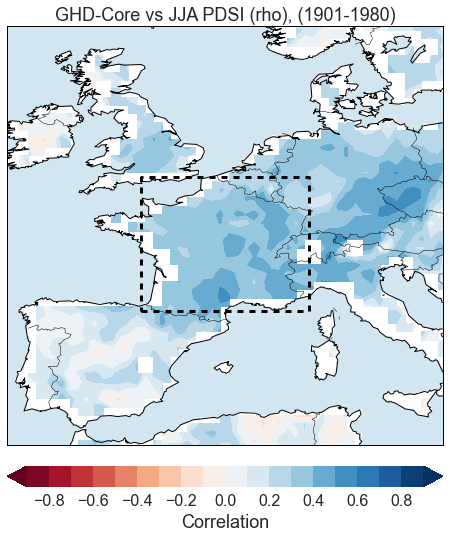

In [9]:
# CORRELATIONS: POINT BY POINT WITH PDSI----------------------------------------------------------
rho_ghd_vs_pdsi = np.zeros((np.size(lat_pdsi),np.size(lon_pdsi)))*np.nan; 

for n_lat in enumerate(lat_pdsi):
    for n_lon in enumerate(lon_pdsi):
    
        # Pull out Individual gridcell pdsi/temp/prec
        pdsi_seas_cell = sub_pdsi[:,n_lat[0],n_lon[0]]

        # Put in NaN if ocean areas (missing values)
        if np.isnan(pdsi_seas_cell[0])==1:

            rho_ghd_vs_pdsi[n_lat[0],n_lon[0]]  = np.nan
        
        # Calculate the correlation if a legitimate observation
        else:   
                             
            # Spearman rank correlations: Temp
            rho,pval = stats.spearmanr(pdsi_seas_cell,sub_ghd)    
            rho_ghd_vs_pdsi[n_lat[0],n_lon[0]]  = rho
            
# Mapping Parameters------------------------------------------------------------------------------
# Set Map Limits and coordinates for mapping
lon_map = lon_pdsi; lat_map = lat_pdsi;

lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
lon_map, lat_map = np.meshgrid(lon_map, lat_map)

site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

# Map of Temperature Correlations
title_txt = 'GHD-Core vs JJA PDSI (rho), ('+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+')'
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# (2) SETUP PROJECTION
m = Basemap(projection=proj_txt,resolution='l',\
        llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
        urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
# (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
# draw meridians
meridians = np.arange(180.,360.,10.)
# (4) COMPUTE MAP PROJECTION COORDINATES
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
cs = m.contourf(x,y,rho_ghd_vs_pdsi,clevs,cmap=plt.cm.RdBu,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
#    # (7) DRAW SITE LOCATION
#    x_loc, y_loc = m(lon_site,lat_site)
#    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
# (8) ADD COLORBAR AND TITLE
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Correlation',fontsize=18)
plt.title(title_txt,fontdict)
cbar.ax.tick_params(labelsize=16)
# (9) SAVE TO OUTPUT
plt.show()
out_txt = '../figures/step03/corrmap.ghdcore.vs.pdsi.'+np.str(np.min(base_period))+'-'+np.str(np.max(base_period))+'.eps'
fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator           
            